In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 讀取 SICK.txt，並只保留 sentence_A, sentence_B, entailment_label
df = pd.read_csv("SICK.txt", sep="\t")
df = df[["sentence_A", "sentence_B", "entailment_label"]]
print("原始資料形狀:", df.shape)

# 可存檔整理後的資料（選用）
#df.to_csv("SICK_filtered.tsv", sep="\t", index=False)


df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["entailment_label"])
print("訓練集形狀:", df_train.shape, "測試集形狀:", df_test.shape)

原始資料形狀: (9840, 3)
訓練集形狀: (7872, 3) 測試集形狀: (1968, 3)


In [27]:
print(df["entailment_label"].value_counts())


entailment_label
NEUTRAL          5595
ENTAILMENT       2821
CONTRADICTION    1424
Name: count, dtype: int64


In [ ]:

def tokenize(text):
    return text.lower().split()

all_texts = df_train["sentence_A"].tolist() + df_train["sentence_B"].tolist()
from collections import Counter
counter = Counter()
for t in all_texts:
    counter.update(tokenize(t))
    
max_vocab_size = 10000
# 保留 <PAD> 與 <UNK>
vocab = {"<PAD>": 0, "<UNK>": 1}
for word, freq in counter.most_common(max_vocab_size - 2):
    vocab[word] = len(vocab)
vocab_size = len(vocab)
print("詞彙大小:", vocab_size)

def text_to_ids(text, vocab, max_length=50):
    tokens = tokenize(text)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) < max_length:
        ids = ids + [vocab["<PAD>"]] * (max_length - len(ids))
    else:
        ids = ids[:max_length]
    return ids

max_length = 50

詞彙大小: 2439


In [ ]:
class SICKDataset(Dataset):
    def __init__(self, df, vocab, max_length):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.max_length = max_length
        self.sentences_A = df["sentence_A"].tolist()
        self.sentences_B = df["sentence_B"].tolist()
        self.labels = df["entailment_label"].tolist()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        sent_A = self.sentences_A[idx]
        sent_B = self.sentences_B[idx]
        ids_A = torch.tensor(text_to_ids(sent_A, self.vocab, self.max_length), dtype=torch.long)
        ids_B = torch.tensor(text_to_ids(sent_B, self.vocab, self.max_length), dtype=torch.long)
        label = self.labels[idx]
        return ids_A, ids_B, label


le = LabelEncoder()
df_train["label_enc"] = le.fit_transform(df_train["entailment_label"])
df_test["label_enc"] = le.transform(df_test["entailment_label"])
num_classes = len(le.classes_)
print("標籤類別:", le.classes_)


def create_dataloader(df, vocab, max_length, batch_size, shuffle=True):
    dataset = SICKDataset(df, vocab, max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

標籤類別: ['CONTRADICTION' 'ENTAILMENT' 'NEUTRAL']


In [ ]:
class EmbeddingLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, max_length, dropout=0.5):
        super(EmbeddingLSTMClassifier, self).__init__()
        self.embedding_A = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm_A = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        
        self.embedding_B = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm_B = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, ids_A, ids_B):
        # sentence_A branch
        emb_A = self.embedding_A(ids_A)  # shape: (batch, max_length, embed_dim)
        out_A, (h_A, _) = self.lstm_A(emb_A)  # h_A shape: (num_layers, batch, hidden_dim)
        h_A = h_A[-1]  # shape: (batch, hidden_dim)
        
        # sentence_B branch
        emb_B = self.embedding_B(ids_B)  # shape: (batch, max_length, embed_dim)
        out_B, (h_B, _) = self.lstm_B(emb_B)
        h_B = h_B[-1]  # shape: (batch, hidden_dim)

        features = torch.cat([h_A, h_B], dim=1)  # shape: (batch, hidden_dim*2)
        
        logits = self.fc(features)
        return logits

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    epoch_list = []
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for ids_A, ids_B, labels in train_loader:
            labels = torch.tensor(le.transform(labels), dtype=torch.long).to(device)
            ids_A, ids_B = ids_A.to(device), ids_B.to(device)
            
            optimizer.zero_grad()
            outputs = model(ids_A, ids_B)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * ids_A.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_acc = correct / total
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for ids_A, ids_B, labels in test_loader:
                labels = torch.tensor(le.transform(labels), dtype=torch.long).to(device)
                ids_A, ids_B = ids_A.to(device), ids_B.to(device)
                outputs = model(ids_A, ids_B)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item() * ids_A.size(0)
                _, preds = torch.max(outputs, 1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)
        
        test_loss = test_running_loss / test_total
        test_acc = test_correct / test_total
        
        epoch_list.append(epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    
    return epoch_list, train_losses, test_losses, train_accuracies, test_accuracies


batch_size = 32
num_epochs = 20
learning_rate = 0.0001

X = df_train.copy()


[比例 100%] 訓練資料筆數: 7872
Epoch 1: Train Loss=0.9846, Train Acc=0.5687 | Test Loss=0.9590, Test Acc=0.5686
Epoch 2: Train Loss=0.9634, Train Acc=0.5686 | Test Loss=0.9591, Test Acc=0.5686
Epoch 3: Train Loss=0.9633, Train Acc=0.5686 | Test Loss=0.9591, Test Acc=0.5686
Epoch 4: Train Loss=0.9639, Train Acc=0.5686 | Test Loss=0.9617, Test Acc=0.5686
Epoch 5: Train Loss=0.9609, Train Acc=0.5686 | Test Loss=0.9594, Test Acc=0.5686
Epoch 6: Train Loss=0.9619, Train Acc=0.5686 | Test Loss=0.9590, Test Acc=0.5686
Epoch 7: Train Loss=0.9621, Train Acc=0.5686 | Test Loss=0.9591, Test Acc=0.5686
Epoch 8: Train Loss=0.9615, Train Acc=0.5686 | Test Loss=0.9519, Test Acc=0.5686
Epoch 9: Train Loss=0.9523, Train Acc=0.5686 | Test Loss=0.9418, Test Acc=0.5686
Epoch 10: Train Loss=0.9447, Train Acc=0.5686 | Test Loss=0.9448, Test Acc=0.5686
Epoch 11: Train Loss=0.9353, Train Acc=0.5686 | Test Loss=0.9377, Test Acc=0.5686
Epoch 12: Train Loss=0.9325, Train Acc=0.5686 | Test Loss=0.9339, Test Acc=0.5686
E

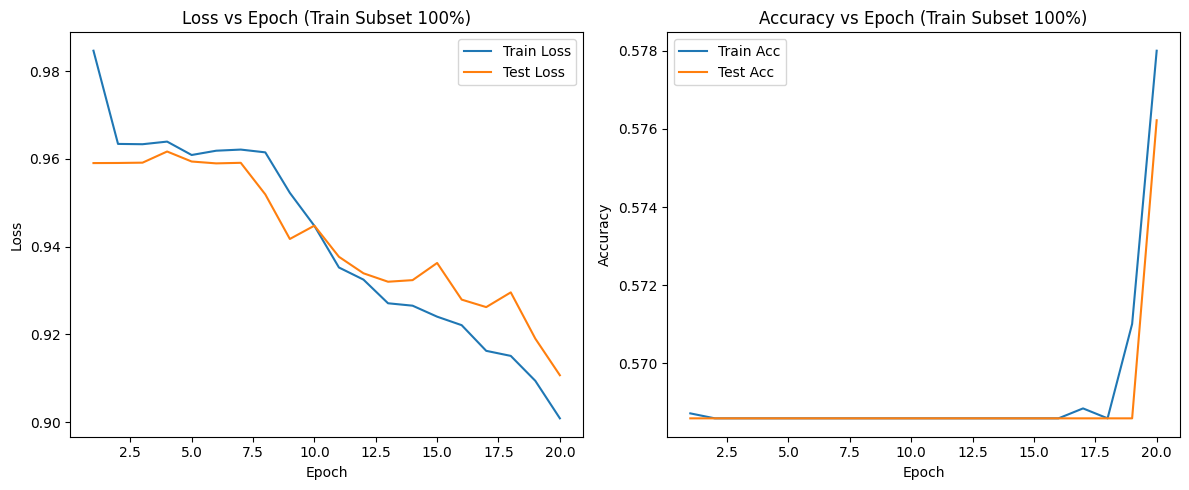

分類報告 (Train Subset 100%):
               precision    recall  f1-score   support

CONTRADICTION       0.46      0.44      0.45       285
   ENTAILMENT       0.00      0.00      0.00       564
      NEUTRAL       0.59      0.90      0.72      1119

     accuracy                           0.58      1968
    macro avg       0.35      0.45      0.39      1968
 weighted avg       0.40      0.58      0.47      1968

Confusion Matrix:
[[ 126    0  159]
 [  36    0  528]
 [ 111    0 1008]]


/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

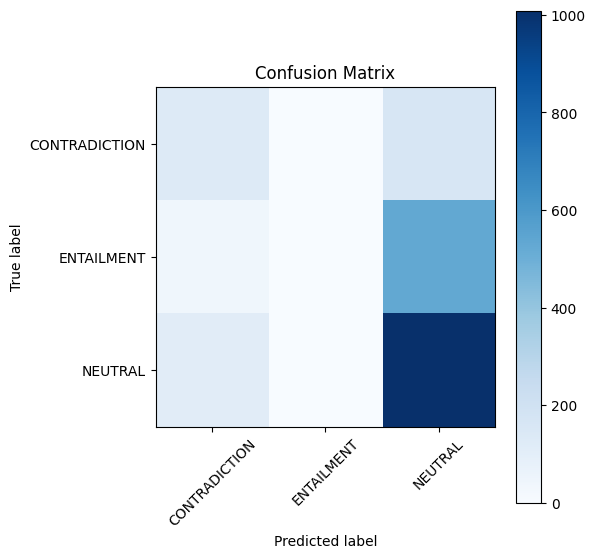


[比例 50%] 訓練資料筆數: 3936
Epoch 1: Train Loss=1.0361, Train Acc=0.4713 | Test Loss=0.9660, Test Acc=0.5686
Epoch 2: Train Loss=0.9697, Train Acc=0.5706 | Test Loss=0.9611, Test Acc=0.5686
Epoch 3: Train Loss=0.9644, Train Acc=0.5701 | Test Loss=0.9647, Test Acc=0.5686
Epoch 4: Train Loss=0.9656, Train Acc=0.5706 | Test Loss=0.9606, Test Acc=0.5686
Epoch 5: Train Loss=0.9615, Train Acc=0.5704 | Test Loss=0.9580, Test Acc=0.5686
Epoch 6: Train Loss=0.9582, Train Acc=0.5704 | Test Loss=0.9592, Test Acc=0.5686
Epoch 7: Train Loss=0.9479, Train Acc=0.5704 | Test Loss=0.9522, Test Acc=0.5686
Epoch 8: Train Loss=0.9363, Train Acc=0.5701 | Test Loss=0.9574, Test Acc=0.5686
Epoch 9: Train Loss=0.9240, Train Acc=0.5704 | Test Loss=0.9684, Test Acc=0.5686
Epoch 10: Train Loss=0.9156, Train Acc=0.5706 | Test Loss=0.9685, Test Acc=0.5686
Epoch 11: Train Loss=0.9098, Train Acc=0.5704 | Test Loss=0.9735, Test Acc=0.5686
Epoch 12: Train Loss=0.9017, Train Acc=0.5704 | Test Loss=0.9704, Test Acc=0.5686
Ep

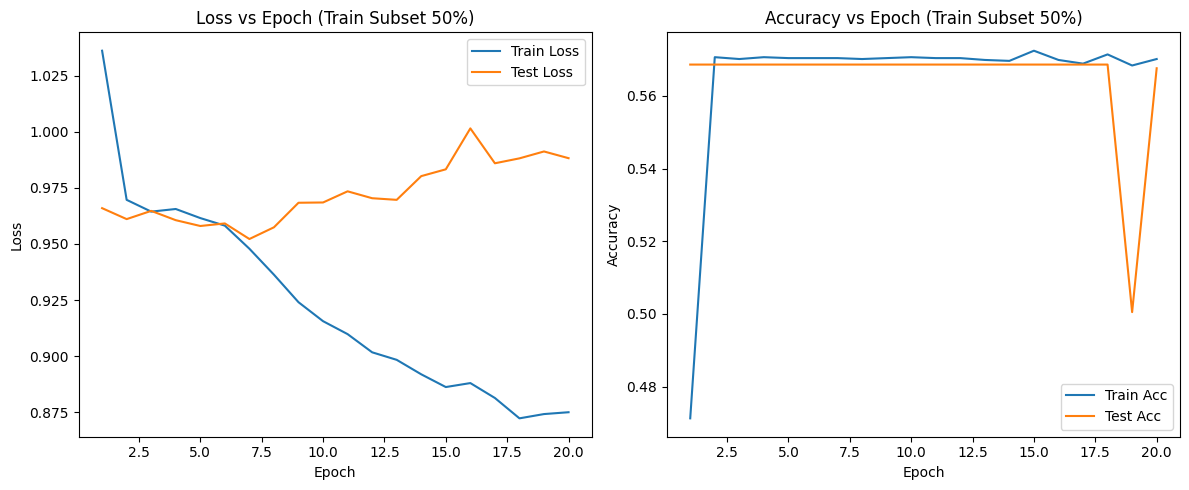

分類報告 (Train Subset 50%):
               precision    recall  f1-score   support

CONTRADICTION       0.00      0.00      0.00       285
   ENTAILMENT       0.00      0.00      0.00       564
      NEUTRAL       0.57      1.00      0.72      1119

     accuracy                           0.57      1968
    macro avg       0.19      0.33      0.24      1968
 weighted avg       0.32      0.57      0.41      1968

Confusion Matrix:
[[   0    0  285]
 [   0    0  564]
 [   0    2 1117]]


/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

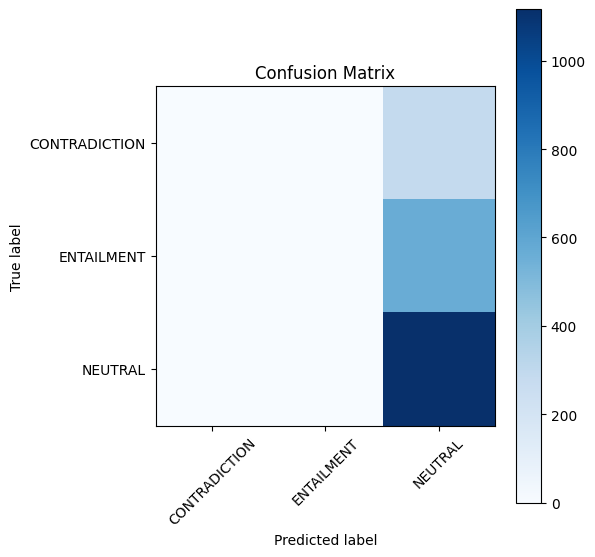


[比例 25%] 訓練資料筆數: 1968
Epoch 1: Train Loss=1.0684, Train Acc=0.5503 | Test Loss=1.0376, Test Acc=0.5686
Epoch 2: Train Loss=0.9820, Train Acc=0.5808 | Test Loss=0.9629, Test Acc=0.5686
Epoch 3: Train Loss=0.9557, Train Acc=0.5808 | Test Loss=0.9609, Test Acc=0.5686
Epoch 4: Train Loss=0.9522, Train Acc=0.5808 | Test Loss=0.9597, Test Acc=0.5686
Epoch 5: Train Loss=0.9558, Train Acc=0.5808 | Test Loss=0.9597, Test Acc=0.5686
Epoch 6: Train Loss=0.9540, Train Acc=0.5808 | Test Loss=0.9590, Test Acc=0.5686
Epoch 7: Train Loss=0.9533, Train Acc=0.5808 | Test Loss=0.9596, Test Acc=0.5686
Epoch 8: Train Loss=0.9585, Train Acc=0.5808 | Test Loss=0.9594, Test Acc=0.5686
Epoch 9: Train Loss=0.9573, Train Acc=0.5808 | Test Loss=0.9590, Test Acc=0.5686
Epoch 10: Train Loss=0.9562, Train Acc=0.5808 | Test Loss=0.9619, Test Acc=0.5686
Epoch 11: Train Loss=0.9502, Train Acc=0.5808 | Test Loss=0.9589, Test Acc=0.5686
Epoch 12: Train Loss=0.9518, Train Acc=0.5808 | Test Loss=0.9590, Test Acc=0.5686
Ep

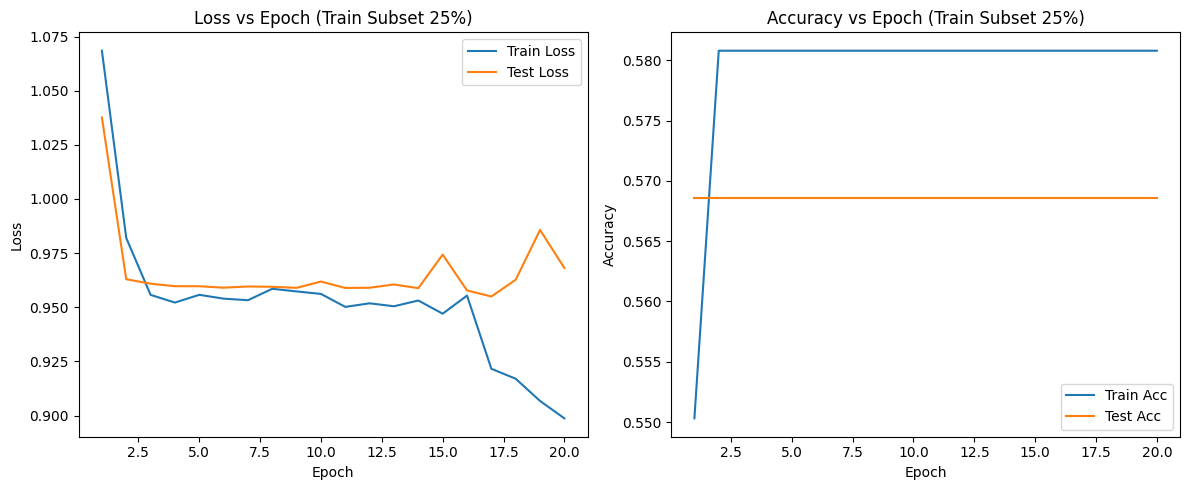

分類報告 (Train Subset 25%):
               precision    recall  f1-score   support

CONTRADICTION       0.00      0.00      0.00       285
   ENTAILMENT       0.00      0.00      0.00       564
      NEUTRAL       0.57      1.00      0.72      1119

     accuracy                           0.57      1968
    macro avg       0.19      0.33      0.24      1968
 weighted avg       0.32      0.57      0.41      1968

Confusion Matrix:
[[   0    0  285]
 [   0    0  564]
 [   0    0 1119]]


/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

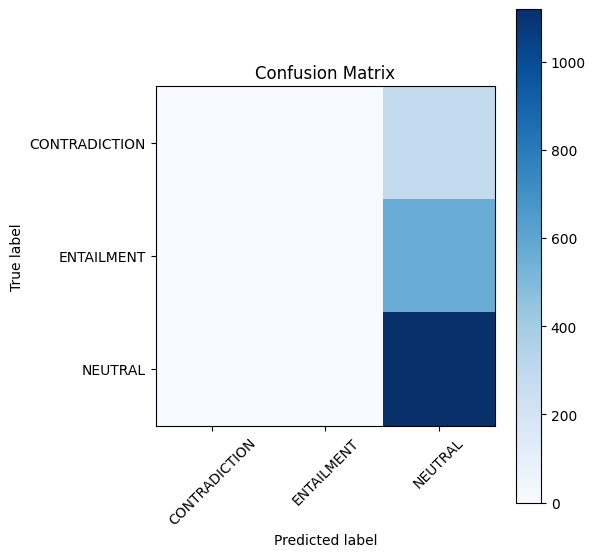


[比例 10%] 訓練資料筆數: 787
Epoch 1: Train Loss=1.0977, Train Acc=0.2935 | Test Loss=1.0870, Test Acc=0.5686
Epoch 2: Train Loss=1.0793, Train Acc=0.5578 | Test Loss=1.0692, Test Acc=0.5686
Epoch 3: Train Loss=1.0606, Train Acc=0.5616 | Test Loss=1.0453, Test Acc=0.5686
Epoch 4: Train Loss=1.0223, Train Acc=0.5616 | Test Loss=0.9766, Test Acc=0.5686
Epoch 5: Train Loss=0.9894, Train Acc=0.5616 | Test Loss=0.9620, Test Acc=0.5686
Epoch 6: Train Loss=0.9809, Train Acc=0.5616 | Test Loss=0.9610, Test Acc=0.5686
Epoch 7: Train Loss=0.9762, Train Acc=0.5616 | Test Loss=0.9588, Test Acc=0.5686
Epoch 8: Train Loss=0.9722, Train Acc=0.5616 | Test Loss=0.9592, Test Acc=0.5686
Epoch 9: Train Loss=0.9654, Train Acc=0.5616 | Test Loss=0.9585, Test Acc=0.5686
Epoch 10: Train Loss=0.9724, Train Acc=0.5629 | Test Loss=0.9583, Test Acc=0.5686
Epoch 11: Train Loss=0.9638, Train Acc=0.5616 | Test Loss=0.9565, Test Acc=0.5686
Epoch 12: Train Loss=0.9619, Train Acc=0.5616 | Test Loss=0.9575, Test Acc=0.5686
Epo

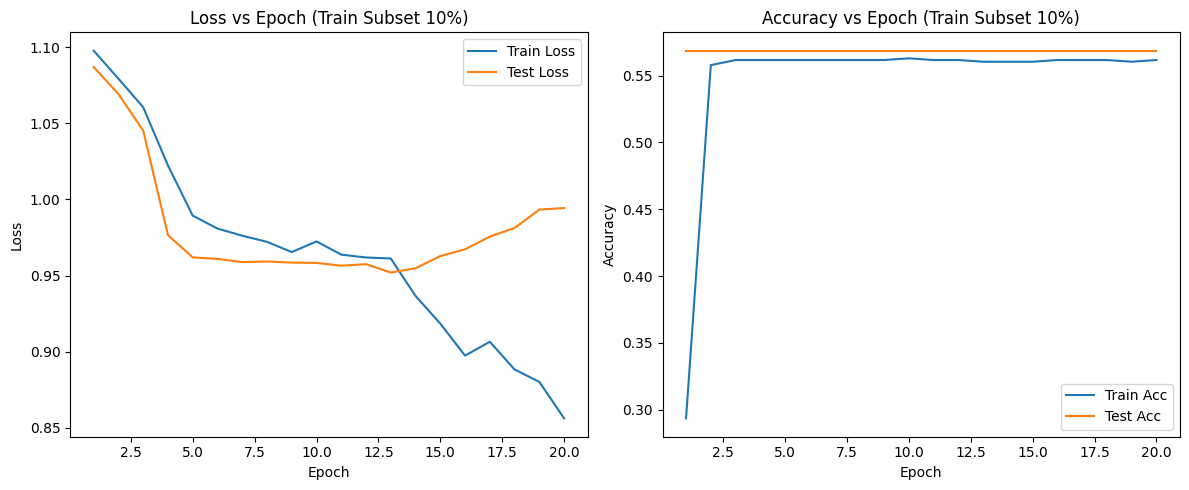

分類報告 (Train Subset 10%):
               precision    recall  f1-score   support

CONTRADICTION       0.00      0.00      0.00       285
   ENTAILMENT       0.00      0.00      0.00       564
      NEUTRAL       0.57      1.00      0.72      1119

     accuracy                           0.57      1968
    macro avg       0.19      0.33      0.24      1968
 weighted avg       0.32      0.57      0.41      1968

Confusion Matrix:
[[   0    0  285]
 [   0    0  564]
 [   0    0 1119]]


/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

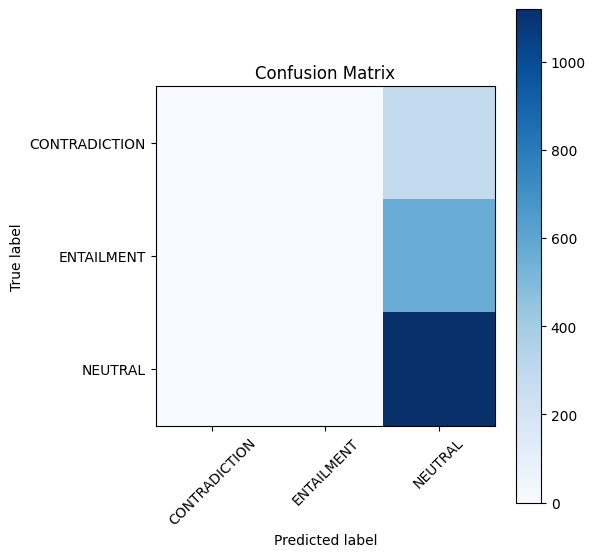

In [25]:
fractions = [1.0, 0.5, 0.25, 0.1]

for frac in fractions:
    num_samples = int(len(X) * frac)
    df_train_subset = X.iloc[:num_samples].reset_index(drop=True)
    subset_percentage = int(frac*100)
    
    train_loader = create_dataloader(df_train_subset, vocab, max_length, batch_size, shuffle=True)
    test_loader = create_dataloader(df_test, vocab, max_length, batch_size, shuffle=False)
    
    print(f"\n[比例 {subset_percentage}%] 訓練資料筆數: {len(df_train_subset)}")
    
    model = EmbeddingLSTMClassifier(vocab_size, embed_dim=128, hidden_dim=128, num_classes=num_classes, max_length=max_length, dropout=0.5)
    model.to(device)
    
    epoch_list, train_losses, test_losses, train_accs, test_accs = train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate)
    
    # 畫圖
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].plot(epoch_list, train_losses, label="Train Loss")
    axs[0].plot(epoch_list, test_losses, label="Test Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title(f"Loss vs Epoch (Train Subset {subset_percentage}%)")
    axs[0].legend()
    
    axs[1].plot(epoch_list, train_accs, label="Train Acc")
    axs[1].plot(epoch_list, test_accs, label="Test Acc")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title(f"Accuracy vs Epoch (Train Subset {subset_percentage}%)")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 使用測試集評估最終模型並印出分類報告
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for ids_A, ids_B, labels in test_loader:
            labels_tensor = torch.tensor(le.transform(labels), dtype=torch.long).to(device)
            ids_A, ids_B = ids_A.to(device), ids_B.to(device)
            outputs = model(ids_A, ids_B)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_tensor.cpu().numpy())
    
    print(f"分類報告 (Train Subset {subset_percentage}%):")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, rotation=45)
    plt.yticks(tick_marks, le.classes_)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()



In [26]:
print(df_train["entailment_label"].value_counts())
print(df_test["entailment_label"].value_counts())

entailment_label
NEUTRAL          4476
ENTAILMENT       2257
CONTRADICTION    1139
Name: count, dtype: int64
entailment_label
NEUTRAL          1119
ENTAILMENT        564
CONTRADICTION     285
Name: count, dtype: int64
